## About this file 

#### Column Profiling:
#### datetime: datetime
#### season: season (1: spring, 2: summer, 3: fall, 4: winter)

#### Spring: February–April (mild, pleasant)/Summer: May–June (hot, dry), but June–September is monsoon (rainy)

#### fall typically covers the months of October and November, after the monsoon ends and before winter begins.

#### holiday: whether day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
#### workingday: if day is neither weekend nor holiday is 1, otherwise is 0.
#### weather: 1: Clear, Few clouds, partly cloudy, partly cloudy 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
#### temp: temperature in Celsius
#### atemp: feeling temperature in Celsius
#### humidity: humidity
#### windspeed: wind speed
#### casual: count of casual users
#### registered: count of registered users
#### count: count of total rental bikes including both casual and registered

In [ ]:
# data from Kaggel link - https://www.kaggle.com/datasets/ranitsarkar01/yulu-bike-sharing-data/data
# code link- https://www.kaggle.com/code/shobhitasati/eda-hypothesis-testing-time-series-analysis

# Problem Statement
1.Which variables are significant in predicting the demand for shared electric cycles in the Indian market?

2.How well do the identified variables describe the demand for electric cycles?

# Report Structure
1.Preparing Data

2.Basic statistics

3.Data Cleaning

4.Graphical Summary

5.Profiling & Advance Statistics

6.Business Insights

7.Recommendations

In [2]:
from calendar import month_abbr
from datetime import timedelta

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
from arch.unitroot import ZivotAndrews
from scikit_posthocs import posthoc_dunn
from scipy import stats
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.api import VAR

In [4]:
df = pd.read_csv('/home/satish/Project/Hypo_venv/Hypothesis_testing/yulu_bike_sharing_dataset.csv')
df.sample(5) 

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
1002,2011-03-06 06:00:00,1,0,0,2,17.22,21.210,94,23.9994,1,1,2
5018,2011-12-03 04:00:00,4,0,0,1,9.02,11.365,75,8.9981,1,7,8
7437,2012-05-09 06:00:00,2,0,1,2,22.96,26.515,88,7.0015,5,121,126
9685,2012-10-07 22:00:00,4,0,0,1,15.58,19.695,87,8.9981,7,72,79
5898,2012-02-01 23:00:00,1,0,1,1,18.86,22.725,63,6.0032,22,75,97


# 2.Basic statistics

In this section, we'll try to identify

1.Number of rows and columns of data.

2.Data type of each column, non-null values in each column and memory usage by the dataset.

3.How data looks like, by taking sample of 5 rows out of it.

4.Distinct values in each column.

5.If dataset contains duplicated rows.

In [5]:
# Number of rows and columns

df.shape

(10886, 12)

In [6]:
# data types and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [7]:
df.sample(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
10322,2012-11-15 12:00:00,4,0,1,2,14.76,18.180,62,7.0015,29,184,213
5830,2012-01-18 03:00:00,1,0,1,2,18.04,21.970,51,32.9975,1,3,4
6165,2012-02-13 03:00:00,1,0,1,1,4.92,7.575,54,7.0015,0,1,1
3001,2011-07-13 23:00:00,3,0,1,1,27.06,30.305,83,16.9979,33,83,116
3983,2011-09-17 00:00:00,3,0,0,1,18.86,22.725,72,11.0014,28,80,108


In [9]:
# Distinct values in each column
df.nunique().rename('Distinct values').reset_index().T.style.hide(axis='columns')

index,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
Distinct values,10886,4,2,2,4,49,60,89,28,309,731,822


In [10]:
# Dataset contains duplicate rows
df.duplicated().sum()

np.int64(0)

# Statistical Summary

In [12]:
df.datetime = pd.to_datetime(df.datetime)

# Renaming 'count' column to 'total_rentals'
df.rename(columns={"count": "total_rentals"}, inplace=True)

statistics = df.copy()

seasons = {1: "spring", 2: "summer", 3: "fall", 4: "winter"}
statistics["season"] = statistics["season"].map(seasons)

working = {1: "working", 0: "non-working"}
statistics["workingday"] = statistics["workingday"].map(working)

holiday = {1: "holiday", 0: "non-holiday"}
statistics["holiday"] = statistics["holiday"].map(holiday)

weather = {
    1: "clear or cloudy",
    2: "misty and cloudy",
    3: "thunderstorm, light rain or snow",
    4: "fog, heavy rain, ice pellets or snow",
}
statistics["weather"] = statistics["weather"].map(weather)

# Seperating date from time.
statistics["date"] = pd.to_datetime(df["datetime"]).dt.date
statistics["time"] = pd.to_datetime(df["datetime"]).dt.time
statistics.drop(columns="datetime", inplace=True)

# Nominal Variables — Holiday, Season, Weather, Working Day
nominal_columns = ["holiday", "season", "weather", "workingday"]

for column in nominal_columns:
    statistics[column] = statistics[column].astype("category")

In [13]:
# verifying the changes 

df.sample(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total_rentals
2597,2011-06-16 03:00:00,2,0,1,2,22.96,26.515,73,6.0032,0,4,4
10462,2012-12-02 08:00:00,4,0,0,2,10.66,14.395,93,6.0032,12,81,93
4962,2011-11-19 20:00:00,4,0,0,2,14.76,18.180,57,7.0015,48,115,163
3526,2011-08-16 20:00:00,3,0,1,1,30.34,33.335,51,0.0000,48,232,280
5490,2012-01-03 21:00:00,1,0,1,1,4.10,5.305,36,15.0013,2,66,68


# Missing value 

In [33]:
# How many years of date we have 
df["datetime"].dt.year.unique().tolist()

[2011, 2012]

In [34]:
# Subtracting first and last date to find range of days.
(df.datetime.dt.date.max() - df.datetime.dt.date.min()).days, len(df.datetime.dt.date.unique())

(718, 456)

In [35]:
# How data is divided for a day — hourly
df.groupby(df.datetime.dt.date).count().datetime

datetime
2011-01-01    24
2011-01-02    23
2011-01-03    22
2011-01-04    23
2011-01-05    23
              ..
2012-12-15    24
2012-12-16    24
2012-12-17    24
2012-12-18    24
2012-12-19    24
Name: datetime, Length: 456, dtype: int64

In [36]:
# Comparing available data with actual numbers.
456 * 24, df.shape[0]

(10944, 10886)

So we discovered missing data at two levels  −
 
Not all the dates are available to us, to be precise,36.5% or 262 Days of data is missing
Data is not available for every hour of every date, to be precise,58 hours for available dates.
If there is no rental at particular hour/day it hasn't been logged

# Outlier Detection and Treatment

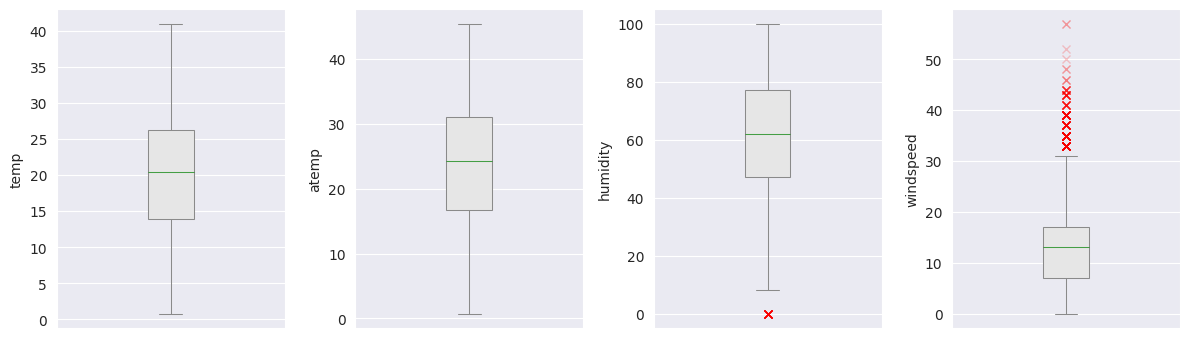

In [42]:
sns.set_style("darkgrid")

columns = ['temp', 'atemp', 'humidity', 'windspeed']
fig, axes = plt.subplots(1, len(columns), figsize=(12, 3.5))

for idx, ax in enumerate(axes.flat):
    sns.boxplot(
        y = columns[idx], data = df,showcaps = True, width = 0.2, ax=ax,
        medianprops = dict(color='g', alpha=0.7), color = "0.9", linewidth = 0.75,
        flierprops = dict(marker='x', markeredgecolor='r', alpha=0.2)
    )

plt.tight_layout()
plt.show()

In [44]:
axes


array([<Axes: ylabel='temp'>, <Axes: ylabel='atemp'>,
       <Axes: ylabel='humidity'>, <Axes: ylabel='windspeed'>],
      dtype=object)